<a href="https://colab.research.google.com/github/eatrero/nlp-with-transformers/blob/main/chap_2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install sklearn
!pip install pandas
!pip install numpy
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.1 MB/s eta 0:00:00


In [ ]:
from datasets import list_datasets, load_dataset

all_datasets = list_datasets()
print(len(all_datasets))
print(all_datasets[:10])

In [ ]:
emotions = load_dataset("emotion")

In [ ]:
emotions

In [ ]:
train_ds = emotions["train"]
train_ds

In [ ]:
print(len(train_ds))
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)
print(train_ds[:5])

In [ ]:
import pandas as pd

# convert DataSet to Pandas DataFrame
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()
emotions["train"].features["label"]


In [ ]:

def map_label(label_num):
    return emotions["train"].features["label"].int2str(label_num)

df["label_name"] = df["label"].apply(map_label)
df.head()



In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
# check length of tweets
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.show()

In [ ]:
emotions.reset_format()

In [ ]:
## Character Tokenization

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

In [ ]:
# convert input_ids to 2d tensor of one-hot vecotrs
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [ ]:
print(f"token: {tokenized_text[0]}")
print(f"tensor index: {input_ids[0]}")
print(f"one-host: {one_hot_encodings[0]}")


token: T
tensor index: 5
one-host: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# Work Tokenization

In [ ]:
## Subwork Tokenization

In [ ]:
# WordPiece tokenizer
from transformers import AutoTokenizer

# use the tokenizer from DistilBERT
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)



In [ ]:
# Alternatively, we could load the tokenizer like so:

from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [ ]:
# reconstruct the tokens back to a string
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size = None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

![img](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0204.png)

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape {inputs['input_ids'].size()}")

Input tensor shape torch.Size([1, 6])


In [32]:
inputs = {k:v.to(device) for k,v in inputs.items()}
print(inputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}


In [33]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [34]:
outputs.last_hidden_state.size()


torch.Size([1, 6, 768])

In [35]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [36]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Creating a feature matrix

In [38]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing the training set

In [39]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train


In [41]:
print(X_scaled[:10])
print(df_emb.info())
df_emb.head()

[[0.36425388 0.58609843 0.3973004  ... 0.7459289  0.5048055  0.6927474 ]
 [0.45346388 0.45611912 0.33501166 ... 0.53971803 0.5051366  0.6042192 ]
 [0.5296934  0.68904227 0.65353525 ... 0.5932565  0.48888594 0.6854378 ]
 ...
 [0.5973916  0.6117593  0.36812377 ... 0.69743276 0.5487274  0.56505704]
 [0.78564215 0.52060026 0.5654133  ... 0.55721724 0.58217263 0.46028203]
 [0.43702337 0.42856577 0.61046076 ... 0.63684297 0.39049518 0.5019837 ]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       16000 non-null  float32
 1   Y       16000 non-null  float32
 2   label   16000 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 250.1 KB
None


,X,Y,label
0,4.307623,6.453608,0
1,-2.890410,5.704431,0
2,5.245677,2.933353,3
3,-2.167681,3.766517,2
4,-3.282958,3.768194,3


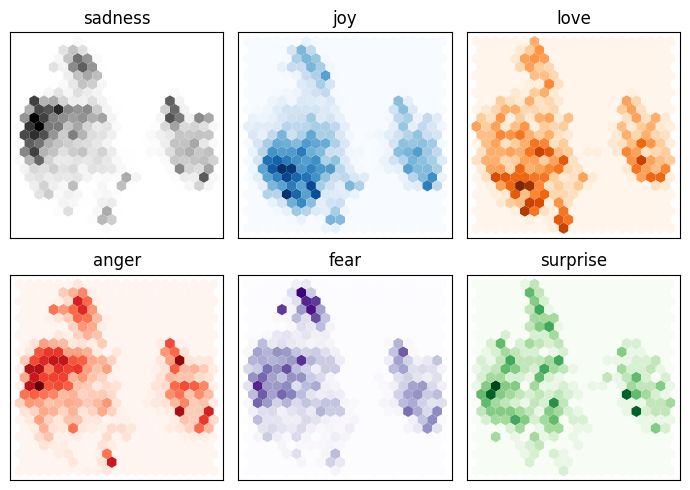

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                  gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [43]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [44]:
# compare to a dummy classifier that picks the most frequent class

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

The simiple classifier with DistilBert embeddings is significantly better than the dummy classifier

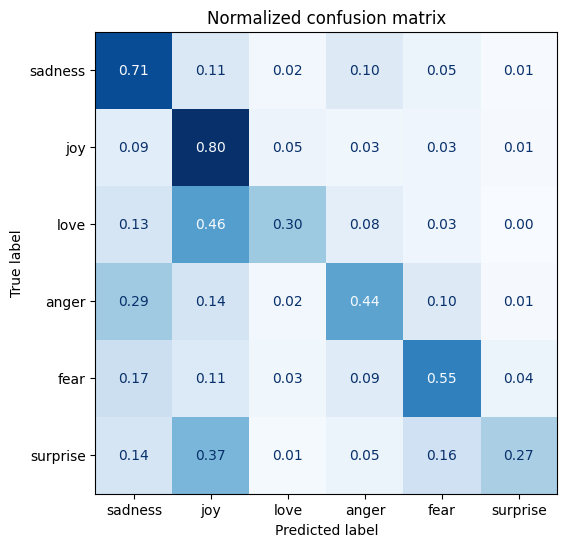

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0206.png)

In fine-tuning approach the whole model is trained along with the classification head

In [46]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.we

In [47]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [48]:
from huggingface_hub import notebook_login
notebook_login()

In [50]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy="epoch",
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=True,
                                 log_level="error")
trainer = Trainer(model=model, args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotions_encoded["train"],
                 eval_dataset=emotions_encoded["validation"],
                 tokenizer=tokenizer)
trainer.train()

Cloning https://huggingface.co/eatrero/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/255M [00:00<?, ?B/s]

Download file runs/Jul09_19-15-01_037ef69a4f12/events.out.tfevents.1688930106.037ef69a4f12.981.0: 100%|#######…

Download file runs/Jul09_19-59-52_037ef69a4f12/events.out.tfevents.1688932794.037ef69a4f12.8548.0: 100%|######…

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Download file runs/Jul09_19-17-14_037ef69a4f12/events.out.tfevents.1688930237.037ef69a4f12.981.1: 100%|#######…

Clean file runs/Jul09_19-15-01_037ef69a4f12/events.out.tfevents.1688930106.037ef69a4f12.981.0:  26%|##5       …

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file runs/Jul09_19-59-52_037ef69a4f12/events.out.tfevents.1688932794.037ef69a4f12.8548.0:  19%|#9       …

Clean file runs/Jul09_19-17-14_037ef69a4f12/events.out.tfevents.1688930237.037ef69a4f12.981.1:  19%|#9        …

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.330171,0.900500,0.895916
2,No log,0.222169,0.923500,0.923451


TrainOutput(global_step=500, training_loss=0.5557653198242187, metrics={'train_runtime': 249.055, 'train_samples_per_second': 128.486, 'train_steps_per_second': 2.008, 'total_flos': 720342861696000.0, 'train_loss': 0.5557653198242187, 'epoch': 2.0})

In [52]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.2221691906452179,
 'test_accuracy': 0.9235,
 'test_f1': 0.9234507249341903,
 'test_runtime': 3.8608,
 'test_samples_per_second': 518.03,
 'test_steps_per_second': 8.288}

In [53]:
y_preds =np.argmax(preds_output.predictions, axis=1)

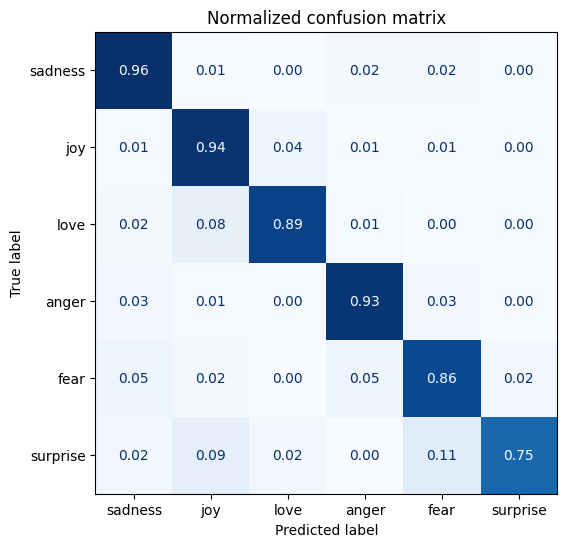

In [54]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [55]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [56]:
trainer.push_to_hub(commit_message="Training completed")

Upload file runs/Jul10_02-14-03_b235cc02dce8/events.out.tfevents.1688955325.b235cc02dce8.1000.0: 100%|########…

To https://huggingface.co/eatrero/distilbert-base-uncased-finetuned-emotion
   b55f785..759ead1  main -> main

   b55f785..759ead1  main -> main

To https://huggingface.co/eatrero/distilbert-base-uncased-finetuned-emotion
   759ead1..a9628cb  main -> main

   759ead1..a9628cb  main -> main



'https://huggingface.co/eatrero/distilbert-base-uncased-finetuned-emotion/commit/759ead17d37cb74da1f92984d7e72522b116b3b8'

In [57]:
# Use our uploaded model in a pipeline
from transformers import pipeline

model_id = "eatrero/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [58]:
custom_tweet = "I saw the movie Across the Spider-Verse and was blown away. Best MCU movie yet."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


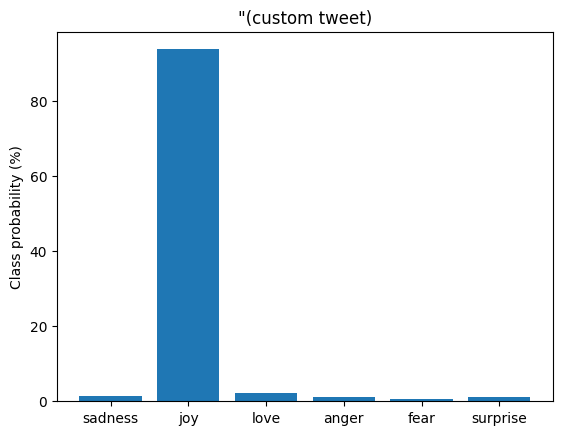

In [59]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"(custom tweet)')
plt.ylabel("Class probability (%)")
plt.show()